In [69]:
import pandas as pd
import plotly.express as px
from glob import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow_io as tfio
from tqdm import tqdm

In [70]:
# Read in data
genres = pd.read_csv('./data/fma_metadata/genres.csv')

# Insert a genre_id with number 0 to make a top-level.
genres.loc[len(genres.index)] = [0, 0, None, 'All Genres', 0]

# Get important info only
genres = genres[['genre_id', '#tracks', 'parent', 'title']]

### Set parent column to title of parent column.
# Create a mapping DataFrame with 'genre_id' and 'title'
genre_mapping = genres[['genre_id', 'title']]

# Merge the original DataFrame with the mapping DataFrame
genres = genres.merge(genre_mapping, left_on='parent', right_on='genre_id', suffixes=('', '_parent'))

# Drop the 'genre_id' column of the parent
genres = genres.drop(columns=['genre_id_parent', 'parent', 'genre_id'])

# Rename the 'title' column to 'parent_title'
genres = genres.rename(columns={'title_parent': 'parent'})

In [71]:
genres.head()

,#tracks,title,parent
0,8693,Avant-Garde,Experimental
1,914,Novelty,Experimental
2,774,Audio Collage,Experimental
3,3237,Field Recordings,Experimental
4,7268,Noise,Experimental


In [72]:
# Make a sunburst plot of the genres
fig2 = px.sunburst(genres, names='title', parents='parent')#, values='#tracks')
# fig2.update_layout(title_text="Two-level Sunburst Diagram", font_size=10)
fig2.show()
#fig2.write_image('./visualizations/hierarchy.png', scale=4)

Additionally, we can visualize counts of genres.

In [73]:
files = glob("./data/fma_medium/**/*.mp3")

medium_track_ids = [int(os.path.basename(file)[:-4]) for file in files]

# Get all track ids and their respective genres
tracks = pd.read_csv('./data/fma_metadata/raw_tracks.csv')[['track_id', 'track_genres']]

tracks = tracks[tracks['track_id'].isin(medium_track_ids)]

tracks.head()

# [{'genre_id': '76', 'genre_title': 'Experimental Pop', 'genre_url': 'http://freemusicarchive.org/genre/Experimental_Pop/'}, {'genre_id': '103', 'genre_title': 'Singer-Songwriter', 'genre_url': 'http://freemusicarchive.org/genre/Singer-Songwriter/'}]

,track_id,track_genres
0,2,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ..."
1,3,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ..."
2,5,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ..."
3,10,"[{'genre_id': '10', 'genre_title': 'Pop', 'gen..."
9,134,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ..."


In [74]:
tracks['parsed_genres'] = tracks['track_genres'].apply(eval)
tracks['num_genres'] = tracks['parsed_genres'].apply(len)

tracks['num_genres'].value_counts().plot(kind='bar')
plt.title('Number of Individual Genres in Each Track')
plt.xlabel('Number of Genres')
plt.ylabel('Count')
plt.savefig('./visualizations/track_genres_count')
plt.close()

Now, here's an important part of the workflow. For the purposes of this project, we only care about the **highest-level parent** genre for each song.

We could delve into trying to predict genres based of a hierarchical structure (as this data has), but that's out of the scope of this project.

If you want to learn more about hierarchical loss functions and the complications that come with them using gradient descent, the following paper is very interesting: https://arxiv.org/abs/1709.01062#:%7E:text=A%20hierarchical%20loss%20and%20its%20problems%20when%20classifying%20non%2Dhierarchically,-Cinna%20Wu%2C%20Mark&text=Failing%20to%20distinguish%20between%20a,are%20both%20breeds%20of%20dogs.

In [75]:
##### Make a new column in our dataframe with ONLY parents.
# First, reload in genre metadata
genres = pd.read_csv('./data/fma_metadata/genres.csv')
genres

genre_parents = []
# Loop through all tracks
for cur_track in tracks['parsed_genres']:
    cur_track_parents = []
    # Loop through all genres in track, making new parents column
    for cur_genre in cur_track:
        if int(cur_genre['genre_id']) in genres['genre_id'].unique():
            # This appends the value of the top level parent to our current track list
            cur_track_parents.append(genres.loc[genres['genre_id'] == int(cur_genre['genre_id'])]['top_level'].values[0])
        else:
            # If it couldn't be found...
            cur_track_parents.append(None)
    genre_parents.append(cur_track_parents)

In [76]:
bad_tracks = []
for idx, track in enumerate(genre_parents):
    # If any value is None
    if None in track:
        bad_tracks.append(idx)

print(len(bad_tracks))

5


In [77]:
for track_idx in bad_tracks:
    print(f"{genre_parents[track_idx]}: {tracks['parsed_genres'].iloc[track_idx]}")

[21, 21, None]: [{'genre_id': '21', 'genre_title': 'Hip-Hop', 'genre_url': 'http://freemusicarchive.org/genre/Hip-Hop/'}, {'genre_id': '539', 'genre_title': 'Rap', 'genre_url': 'http://freemusicarchive.org/genre/rap/'}, {'genre_id': '806', 'genre_title': 'hiphop', 'genre_url': 'http://freemusicarchive.org/genre/hiphop/'}]
[21, 21, None]: [{'genre_id': '21', 'genre_title': 'Hip-Hop', 'genre_url': 'http://freemusicarchive.org/genre/Hip-Hop/'}, {'genre_id': '539', 'genre_title': 'Rap', 'genre_url': 'http://freemusicarchive.org/genre/rap/'}, {'genre_id': '806', 'genre_title': 'hiphop', 'genre_url': 'http://freemusicarchive.org/genre/hiphop/'}]
[21, 21, None]: [{'genre_id': '21', 'genre_title': 'Hip-Hop', 'genre_url': 'http://freemusicarchive.org/genre/Hip-Hop/'}, {'genre_id': '539', 'genre_title': 'Rap', 'genre_url': 'http://freemusicarchive.org/genre/rap/'}, {'genre_id': '806', 'genre_title': 'hiphop', 'genre_url': 'http://freemusicarchive.org/genre/hiphop/'}]
[21, 21, None]: [{'genre_id'

We can see above that the only invalid genres are "hiphop", which all of these tracks already have the valid genre for.

So we can just ignore these.

Now, let's investigate the tracks that have multiple top-level genres.

In [78]:
# First, fix the Nones
for track_idx in bad_tracks:
    genre_parents[track_idx] = genre_parents[track_idx][:2]

# Then, look at all tracks that have multiple top-level genres:
test = [track for track in genre_parents if len(set(track)) > 1]

print(len(test))

0


Amazing! (but maybe concerning for other reasons...) - There are no tracks which fall under multiple top-level genres.

This makes our analysis a lot easier.

Now, let's incorporate this info into our original dataframe:

In [79]:
genre_parents = [track[0] for track in genre_parents]

In [80]:
# Make a new column for these parent values
tracks['parent_genre_id'] = genre_parents
# Do a join for the value in our genres dataframe to get the genre title
new_df = tracks.merge(genres, how='left', left_on='parent_genre_id', right_on='genre_id')
new_df['title']
tracks['parent_genre_title'] = list(new_df['title'])

tracks

,track_id,track_genres,parsed_genres,num_genres,parent_genre_id,parent_genre_title
0,2,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...","[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",1,21,Hip-Hop
1,3,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...","[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",1,21,Hip-Hop
2,5,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...","[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",1,21,Hip-Hop
3,10,"[{'genre_id': '10', 'genre_title': 'Pop', 'gen...","[{'genre_id': '10', 'genre_title': 'Pop', 'gen...",1,10,Pop
9,134,"[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...","[{'genre_id': '21', 'genre_title': 'Hip-Hop', ...",1,21,Hip-Hop
...,...,...,...,...,...,...
109704,155297,"[{'genre_id': '18', 'genre_title': 'Soundtrack...","[{'genre_id': '18', 'genre_title': 'Soundtrack...",3,1235,Instrumental
109705,155298,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...","[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",2,17,Folk
109713,155306,"[{'genre_id': '17', 'genre_title': 'Folk', 'ge...","[{'genre_id': '17', 'genre_title': 'Folk', 'ge...",2,17,Folk
109714,155307,"[{'genre_id': '1', 'genre_title': 'Avant-Garde...","[{'genre_id': '1', 'genre_title': 'Avant-Garde...",1,38,Experimental


Great! Now, we don't really need the `track_genres`, `parsed_genres`, or `num_genres` columns anymore.

In [81]:
tracks = tracks.drop(columns=['track_genres', 'parsed_genres', 'num_genres'])
tracks

,track_id,parent_genre_id,parent_genre_title
0,2,21,Hip-Hop
1,3,21,Hip-Hop
2,5,21,Hip-Hop
3,10,10,Pop
9,134,21,Hip-Hop
...,...,...,...
109704,155297,1235,Instrumental
109705,155298,17,Folk
109713,155306,17,Folk
109714,155307,38,Experimental


Additionally, we don't really care about the original genre IDs anymore.

It will be easier to have classes starting from 0 and incrementing by 1 for the network itself:

In [82]:
print(f"Unique values in current IDs: {tracks['parent_genre_id'].unique()}")
print(f"Unique values in genre titles: {tracks['parent_genre_title'].unique()}")

# Let's just do it based on the titles list:
for idx, title in enumerate(tracks['parent_genre_title'].unique()):
    tracks.loc[tracks['parent_genre_title'] == title, 'parent_genre_id'] = idx

tracks.head(20)

Unique values in current IDs: [  21   10   12   17   38    4   15    2   14    3   20    9    5    8
 1235   13]
Unique values in genre titles: ['Hip-Hop' 'Pop' 'Rock' 'Folk' 'Experimental' 'Jazz' 'Electronic'
 'International' 'Soul-RnB' 'Blues' 'Spoken' 'Country' 'Classical'
 'Old-Time / Historic' 'Instrumental' 'Easy Listening']


,track_id,parent_genre_id,parent_genre_title
0,2,0,Hip-Hop
1,3,0,Hip-Hop
2,5,0,Hip-Hop
3,10,1,Pop
9,134,0,Hip-Hop
11,136,2,Rock
14,139,3,Folk
15,140,3,Folk
16,141,3,Folk
22,148,4,Experimental


We can now visualize how many tracks have each genre:

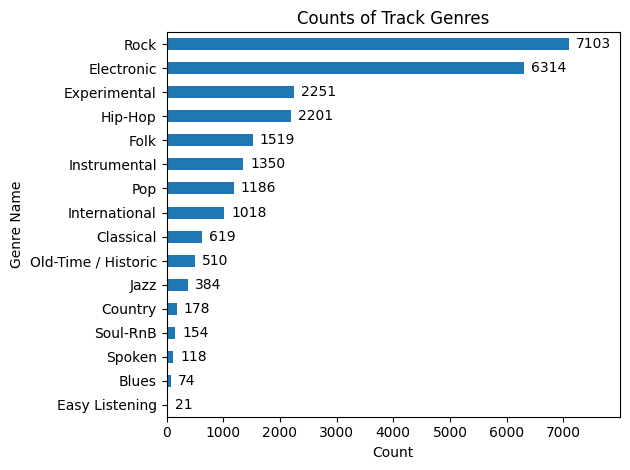

In [83]:
ax = tracks.parent_genre_title.value_counts().sort_values().plot(kind='barh')
plt.title('Counts of Track Genres')
plt.xlabel('Count')
plt.ylabel('Genre Name')
# Add value labels to the bars
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points')
plt.xlim(0, 7999)
plt.tight_layout()
plt.savefig('./visualizations/genres_count.png')

Let's investigate the sample rates of our files.

In [84]:
def load_mp3(fpath):
    audio = tfio.audio.AudioIOTensor(fpath)

    return audio

rates = {}
for idx, file in enumerate(tqdm(files)):
    mp3 = load_mp3(file)
    rates[medium_track_ids[idx]] = mp3.rate.numpy()

100%|██████████| 25000/25000 [02:20<00:00, 178.14it/s]


In [85]:
# This will give the unique sample rate values
print(set(rates.values()))

for rate in set(rates.values()):
    print(f"Count of sample rate {rate}: {list(rates.values()).count(rate)}")

{48000, 32000, 22050, 44100}
Count of sample rate 48000: 1090
Count of sample rate 32000: 17
Count of sample rate 22050: 38
Count of sample rate 44100: 23855


We can see from above that there are 4 different sample rates in our data:
48000, 32000, 22050, and 44100.

Since 32000 and 22050 only have 17 and 38 respectively, I'm comfortable with removing these.
This allows me to avoid downsampling everything else for consistency.

In the music world, 44100Hz sample rate is standard (used for CDs), so being versatile to lower sample rates is not worth the loss in data quality.

Read this for more info: https://www.adobe.com/uk/creativecloud/video/discover/audio-sampling.html

There's only 55 tracks that are lower, so we can easily remove them without causing issues.

In [86]:
bad_sample_rates = []

for track in rates:
    if rates[track] < 44100:
        bad_sample_rates.append(track)

# Remove these from the dataset
tracks = tracks[~tracks['track_id'].isin(bad_sample_rates)]
len(tracks)

24945

As a last step, let's make another column with the filename of each track.

In [87]:
# Make new column
tracks.loc[:, ['fpath']] = None

# Get the paths relative to the fma_medium folder
rel_paths = [file[file.find('fma_medium') + 10:] for file in files]

for path in rel_paths:
    # Find the id (without leading zeros)
    id = int(path.split(os.sep)[-1][:-4].lstrip("0"))
    tracks.loc[tracks['track_id'] == id, 'fpath'] = path

tracks.head(20)

C:\Users\Peter\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,track_id,parent_genre_id,parent_genre_title,fpath
0,2,0,Hip-Hop,\000\000002.mp3
1,3,0,Hip-Hop,\000\000003.mp3
2,5,0,Hip-Hop,\000\000005.mp3
3,10,1,Pop,\000\000010.mp3
9,134,0,Hip-Hop,\000\000134.mp3
11,136,2,Rock,\000\000136.mp3
14,139,3,Folk,\000\000139.mp3
15,140,3,Folk,\000\000140.mp3
16,141,3,Folk,\000\000141.mp3
22,148,4,Experimental,\000\000148.mp3


Awesome! Let's save our data to a CSV for future use.

In [88]:
tracks.to_csv('./data/processed_genres.csv')